In [2]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 198 kB 35.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=2322475d592be151468931712b347f19082c709fcd372011d3fd5a2163eee5de
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession

In [8]:
from google.colab import files
 
 
uploaded = files.upload()

Saving Churn_Modelling.csv to Churn_Modelling.csv


In [9]:
spark = SparkSession.builder.appName("Customer Churn Pridictor").getOrCreate()

In [138]:
df = spark.read.csv("Churn_Modelling.csv", inferSchema=True, header=True)

In [266]:
import seaborn as sns
import pandas as pd
panda_df = df.toPandas()

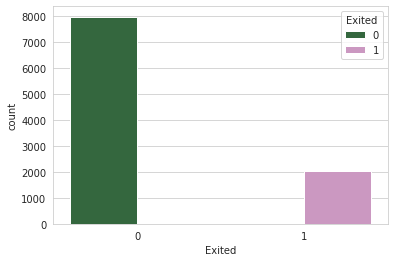

In [268]:
sns.countplot(x='Exited', hue='Exited', data=panda_df, palette='cubehelix')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


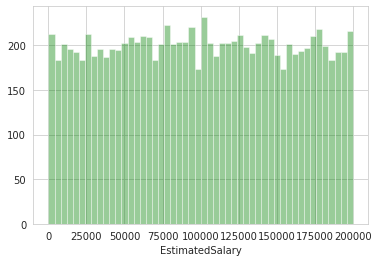

In [273]:
sns.distplot(panda_df['EstimatedSalary'],kde=False,color='green',bins=50)

In [154]:
from pyspark.sql.functions import when

In [157]:
df2 = df.withColumn("HasCrCard", when(df.HasCrCard == 0, -1).otherwise(df.HasCrCard))

In [162]:
final_df = df2.withColumn("IsActiveMember", when(df2.IsActiveMember == 0, -1).otherwise(df2.IsActiveMember))

In [163]:
final_df.printSchema()

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [164]:
final_df.describe().show()

+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-------------------+
|summary|         RowNumber|       CustomerId|Surname|      CreditScore|Geography|Gender|               Age|            Tenure|          Balance|     NumOfProducts|         HasCrCard|    IsActiveMember|  EstimatedSalary|             Exited|
+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-------------------+
|  count|             10000|            10000|  10000|            10000|    10000| 10000|             10000|             10000|            10000|             10000|             10000|             10000|            10000|              10000|
|   mean|            5000.5|  1.5690

In [165]:
final_df.columns

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [166]:
from pyspark.ml.feature import VectorAssembler

In [219]:
assembler = VectorAssembler(inputCols=[
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',], outputCol= "features")

In [220]:
output = assembler.transform(final_df)

In [221]:
df1 = output.select("features", "Exited")

In [222]:
df1.show()

+--------------------+------+
|            features|Exited|
+--------------------+------+
|[1.5634602E7,619....|     1|
|[1.5647311E7,608....|     0|
|[1.5619304E7,502....|     1|
|[1.5701354E7,699....|     0|
|[1.5737888E7,850....|     0|
|[1.5574012E7,645....|     1|
|[1.5592531E7,822....|     0|
|[1.5656148E7,376....|     1|
|[1.5792365E7,501....|     0|
|[1.5592389E7,684....|     0|
|[1.5767821E7,528....|     0|
|[1.5737173E7,497....|     0|
|[1.5632264E7,476....|     0|
|[1.5691483E7,549....|     0|
|[1.5600882E7,635....|     0|
|[1.5643966E7,616....|     0|
|[1.5737452E7,653....|     1|
|[1.5788218E7,549....|     0|
|[1.5661507E7,587....|     0|
|[1.5568982E7,726....|     0|
+--------------------+------+
only showing top 20 rows



In [250]:
train, test = df1.randomSplit([0.8, 0.2], seed=42)

In [251]:
from pyspark.ml.classification import LogisticRegression

In [252]:
lr = LogisticRegression(labelCol="Exited")

In [253]:
lrm = lr.fit(train)

In [254]:
lrm_object = lrm.summary

In [255]:
lrm_object.predictions.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+------+--------------------+--------------------+----------+
|            features|Exited|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|[1.5565701E7,698....|   0.0|[0.63239187866997...|[0.65303161541779...|       0.0|
|[1.5565706E7,612....|   1.0|[2.65309616992260...|[0.93420156502948...|       0.0|
|[1.5565779E7,627....|   0.0|[1.67830813728695...|[0.84268037061248...|       0.0|
|[1.5565796E7,745....|   0.0|[0.42560914428032...|[0.60482468666848...|       0.0|
|[1.5565806E7,532....|   0.0|[1.49770671075463...|[0.81723219110628...|       0.0|
|[1.5565879E7,845....|   0.0|[3.63396136991776...|[0.97426825831028...|       0.0|
|[1.5565996E7,653....|   0.0|[2.23663964169405...|[0.90349185112617...|       0.0|
|[1.556603E7,497.0...|   1.0|[0.64001803203621...|[0.65475753676137...|       0.0|
|[1.5566091E7,545....|   0.0|[1.76428261330664...|[0.85374521632955...|       0.0|
|[1.

In [256]:
lrm_object.predictions.describe().show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-------+-------------------+-------------------+
|summary|             Exited|         prediction|
+-------+-------------------+-------------------+
|  count|               8079|               8079|
|   mean|0.20101497710112637|0.05718529520980319|
| stddev| 0.4007840294045782| 0.2322107050485127|
|    min|                0.0|                0.0|
|    max|                1.0|                1.0|
+-------+-------------------+-------------------+



In [257]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [258]:
pred_lables = lrm.evaluate(test)

In [259]:
pred_lables.predictions.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+------+--------------------+--------------------+----------+
|            features|Exited|       rawPrediction|         probability|prediction|
+--------------------+------+--------------------+--------------------+----------+
|[1.5565714E7,601....|     0|[1.44565497746372...|[0.80932882992781...|       0.0|
|[1.5565878E7,631....|     0|[3.16434283622093...|[0.95947016442252...|       0.0|
|[1.5565891E7,709....|     0|[1.56473658549014...|[0.82703197188069...|       0.0|
|[1.5566139E7,526....|     0|[1.17365616046390...|[0.76380524797203...|       0.0|
|[1.5566292E7,574....|     0|[2.56798469060461...|[0.92877248998153...|       0.0|
|[1.556638E7,586.0...|     0|[2.74837705156858...|[0.93982162632686...|       0.0|
|[1.5566563E7,777....|     1|[1.45631793003376...|[0.81096886568566...|       0.0|
|[1.5566735E7,548....|     0|[2.08128768788763...|[0.88907109345207...|       0.0|
|[1.5567078E7,789....|     0|[3.23346751738821...|[0.96207447577094...|       0.0|
|[1.

In [260]:
eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol= 'Exited')

In [261]:
model_accuracy = eval.evaluate(pred_lables.predictions)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [262]:
print("Model Accuracy = " + str(model_accuracy * 100) + "%")

Model Accuracy = 56.33401519579194%


In [284]:
final_model = lr.fit(df1)

In [285]:
x= [
 'CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',]
data=[15465701, 345, 35, 7, 243221, 2, 1, -1, 21250]
new_paitentid=pd.DataFrame([data],columns=x)
new_paitentid.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15465701,345,35,7,243221,2,1,-1,21250


In [286]:
spark_new_paitentid=spark.createDataFrame(new_paitentid) 

In [287]:
spark_new_paitentid.printSchema()

root
 |-- CustomerId: long (nullable = true)
 |-- CreditScore: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Tenure: long (nullable = true)
 |-- Balance: long (nullable = true)
 |-- NumOfProducts: long (nullable = true)
 |-- HasCrCard: long (nullable = true)
 |-- IsActiveMember: long (nullable = true)
 |-- EstimatedSalary: long (nullable = true)



In [288]:
spark_new_paitentid_valid = assembler.transform(spark_new_paitentid)

In [289]:
spark_new_paitentid_valid.printSchema()

root
 |-- CustomerId: long (nullable = true)
 |-- CreditScore: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Tenure: long (nullable = true)
 |-- Balance: long (nullable = true)
 |-- NumOfProducts: long (nullable = true)
 |-- HasCrCard: long (nullable = true)
 |-- IsActiveMember: long (nullable = true)
 |-- EstimatedSalary: long (nullable = true)
 |-- features: vector (nullable = true)



In [306]:
results = final_model.transform(spark_new_paitentid_valid)

In [308]:
print("The model shows Customer with attributes\n")
results.select('CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary').show()

The model shows Customer with attributes

+----------+-----------+---+------+-------+-------------+---------+--------------+---------------+----------+
|CustomerId|CreditScore|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|prediction|
+----------+-----------+---+------+-------+-------------+---------+--------------+---------------+----------+
|  15465701|        345| 35|     7| 243221|            2|        1|            -1|          21250|       0.0|
+----------+-----------+---+------+-------+-------------+---------+--------------+---------------+----------+



In [312]:
results.select('prediction').show()

+----------+
|prediction|
+----------+
|       0.0|
+----------+

